<a href="https://colab.research.google.com/github/gi1no/Education/blob/main/ThinkStats/chap11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Multiple Regression

The linear least squares fit in the previous chapter is an example of **regression**, which is the more general problem of modeling the relationship between one set of variables, called **response variables** or dependent variables, and another set of variables, called **explanatory variables** or independent variables.

In the examples in the previous chapter, there is only one response variable and one explanatory variable, which is called **simple regression**.
In this chapter, we move on to **multiple regression**, with more than one explanatory variable, but still only one response variable.
If there is more than one response variable, that's multivariate regression, which we won't cover in this book.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap11.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [2]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=92b99566b1d45fb7545cefdb4bfc5f1260b3ef381bb30463f16548332b2cd238
  Stored in directory: /root/.cache/pip/wheels/96/04/f1/a934ef1f5f3db621dc39566b2c7de45b8c6916044be6a9c9ac
Successfully built empiricaldist


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## StatsModels

In the previous chapter we used the SciPy function `linregress` to compute least squares fits.
This function performs simple regression, but not multiple regression.
For that, we'll use `StatsModels`, a package that provides several forms of regression and other analyses.

As an first example, we'll continue exploring the penguin data.

The following cell downloads the data from a repository created by Allison Horst.

Horst AM, Hill AP, Gorman KB (2020). palmerpenguins: Palmer Archipelago (Antarctica) penguin data. R package version 0.1.0. https://allisonhorst.github.io/palmerpenguins/. doi: 10.5281/zenodo.3960218.

The data was collected as part of the research that led to this paper: Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

In [4]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

Downloaded penguins_raw.csv


When we load the data, we'll use the following dictionary to give the columns names that don't contain spaces, which will make them easier to use with StatsModels.

In [5]:
columns = {
    "Body Mass (g)": "mass",
    "Flipper Length (mm)": "flipper_length",
    "Culmen Length (mm)": "culmen_length",
    "Culmen Depth (mm)": "culmen_depth",
}

Now we can load the data, drop the rows with missing mass, and rename the columns.

In [6]:
penguins = (
    pd.read_csv("penguins_raw.csv")
    .dropna(subset=["Body Mass (g)"])
    .rename(columns=columns)
)
penguins.shape

(342, 17)

The dataset contains three species of penguins.
We'll work with just the Adélie penguins.

In [7]:
adelie = penguins.query('Species.str.startswith("Adelie")').copy()
len(adelie)

151

In the previous chapter, we computed a least squares fit between the penguins' flipper lengths and weights.

In [8]:
flipper_length = adelie["flipper_length"]
body_mass = adelie["mass"]

As a reminder, here's how we did that with `linregress`.

In [9]:
from scipy.stats import linregress

result_linregress = linregress(flipper_length, body_mass)
result_linregress.intercept, result_linregress.slope

(np.float64(-2535.8368022002514), np.float64(32.83168975115009))

`StatsModels` provides two interfaces (APIs) -- we'll use the "formula" API, which uses the Patsy formula language to specify the response and explanatory variables.
The following formula string specifies that the response variable, `mass`, is a linear function of one explanatory variable, `flipper_length`.

In [10]:
formula = "mass ~ flipper_length"

We can pass this formula to the `StatsModels` function `ols`, along with the data.

In [11]:
import statsmodels.formula.api as smf

model = smf.ols(formula, data=adelie)
type(model)

statsmodels.regression.linear_model.OLS

The name `ols` stands for "ordinary least squares", which indicates that this function computes a least squares fit under the most common, or "ordinary", set of assumptions.

The result is an `OLS` object that represents the model.
In general, a model is a simplified description of the relationship between variables.
In this example, it's a linear model, which means that it assumes that the response variable is a linear function of the explanatory variables.

The `fit` method fits the model to the data and returns a `RegressionResults` object that contains the result.

In [12]:
result_ols = model.fit()

In [13]:
# Technically it's a RegressionResultsWrapper

type(result_ols)

statsmodels.regression.linear_model.RegressionResultsWrapper

The `RegressionResults` object contains a lot of information, so `thinkstats` provides a function that just displays the information we need for now.

In [14]:
from thinkstats import display_summary

display_summary(result_ols)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2535.8368,964.798,-2.628,0.009,-4442.291,-629.382
flipper_length,32.8317,5.076,6.468,0.000,22.801,42.862


R-squared:,0.2192


The first column contains the intercept and slope, which are the **coefficients** of the model.
We can confirm that they are the same as the coefficients we got from `linregress`.

In [15]:
result_linregress.intercept, result_linregress.slope

(np.float64(-2535.8368022002514), np.float64(32.83168975115009))

The second column contains the standard errors of the coefficients -- again, they are the same as the values we got from `linregress`.

In [16]:
result_linregress.intercept_stderr, result_linregress.stderr,

(np.float64(964.7984274994059), np.float64(5.076138407990821))

The next column reports $t$ statistics, which are used to compute p-values -- we can ignore them, because the p-values are in the next column, labeled `P>|t|`.
The p-value for `flipper_length` is rounded down to 0, but we can display it like this.

In [17]:
result_ols.pvalues["flipper_length"]

np.float64(1.3432645947789321e-09)

And confirm that `linregress` computed the same result.

In [18]:
result_linregress.pvalue

np.float64(1.3432645947790051e-09)

The p-value is very small, which means that if there were actually no relationship between weight and flipper length, it is very unlikely we would see a slope as big as the estimated value by chance.

The last two columns, labeled `[0.025` and `0.975]`, report 95% confidence intervals for the intercept and slope.
So the 95% CI for the slope is [22.8, 42.9].

The last line reports the $R^2$ value of the model, which is about 0.22 -- that means we can reduce MSE by about 22% if we use flipper length to predict weight, compared to using only the average weight.

The $R^2$ value we get from simple correlation is the square of the correlation coefficient, $r$.
So we can compare `rsquared` computed by `ols` with the square of the `rvalue` computed by `linregress`.

In [19]:
result_ols.rsquared, result_linregress.rvalue**2

(np.float64(0.21921282646854878), np.float64(0.21921282646854875))

hey are the same except for a small difference due to floating-point approximation.

Before we go on to multiple regression, let's compute one more simple regression, with `culmen_length` as the explanatory variable (the culmen is the top ridge of the bill).

In [20]:
formula = "mass ~ culmen_length"
result = smf.ols(formula, data=adelie).fit()
display_summary(result)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,34.8830,458.439,0.076,0.939,-870.998,940.764
culmen_length,94.4998,11.790,8.015,0.000,71.202,117.798


R-squared:,0.3013


Again, the p-value of the slope is very small, which means that if there were actually no relationship between mass and culmen length, it is unlikely we would see a slope this big by chance.
You might notice that the p-value associated with the intercept is large, but that's not a problem because we are not concerned about whether the intercept might be zero.
In this model, the intercept is close to zero, but that's just a coincidence -- it doesn't indicate a problem with the model.

The $R^2$ value for this model is about 0.30, so the reduction in MSE is a little higher if we use culmen length rather than flipper length as an explanatory variable (the $R^2$ value with flipper length is 0.22).
Now, let's see what happens if we combine them.

## On To Multiple Regression

Here's the Patsy formula for a multiple regression model where mass is a linear function of both flipper length and culmen length.

In [21]:
formula = "mass ~ flipper_length + culmen_length"

And here is the result of fitting this model to the data.

In [22]:
result = smf.ols(formula, data=adelie).fit()
display_summary(result)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3573.0817,866.739,-4.122,0.000,-5285.864,-1860.299
flipper_length,22.7024,4.742,4.787,0.000,13.331,32.074
culmen_length,76.3402,11.644,6.556,0.000,53.331,99.350


R-squared:,0.3949


This model has three coefficients: an intercept and two slopes.
The slope associated with flipper length is 22.7, which means we expect a penguin with a longer flipper, by one millimeter, to weight more, by 22.7 grams -- assuming that culmen length is the same.
Similarly, we expect a penguin with a longer culmen, by one millimeter, to weight more, by 76.3 grams -- assuming that flipper length is the same.

The p-values associated with both slopes are small, which means that the contribution of both explanatory variables would be unlikely to happen by chance.

And the $R^2$ value is 0.39, higher than the model with only culmen length (0.30) and the model with only flipper length (0.22).
So predictions based on both explanatory variables are better than predictions based on either one alone.

But they are not as much better as we might have hoped.
If flipper length reduces MSE by 22% and culmen length reduces it by 30%, why don't the two of them together reduce it by a total of 52%?
The reason is that the explanatory variables are correlated with each other.

In [23]:
from thinkstats import corrcoef

corrcoef(adelie, "flipper_length", "culmen_length")

np.float64(0.32578471516515944)

A penguin with a longer flipper also has a longer culmen, on average.
The explanatory variables contain some information about each other, which means that they contain some of the same information about the response variable.
When we add an explanatory variable to the model, the improvement in $R^2$ reflects only the new information provided by the new variable.

We see the same pattern if we add culmen depth as a third explanatory variable.

In [24]:
formula = "mass ~ flipper_length + culmen_length + culmen_depth"
result = smf.ols(formula, data=adelie).fit()
display_summary(result)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4341.3019,795.117,-5.460,0.000,-5912.639,-2769.964
flipper_length,17.4215,4.385,3.973,0.000,8.756,26.087
culmen_length,55.3676,11.133,4.973,0.000,33.366,77.369
culmen_depth,140.8946,24.216,5.818,0.000,93.037,188.752


R-squared:,0.5082


This model has four coefficients.
All of the p-values are small, which means that the contribution of each explanatory variable would be unlikely to happen by chance.
And the $R^2$ value is about 0.51, somewhat better than the previous model with two explanatory variables (0.39), and better than either model with a single variable (0.22 and 0.30).

But again, the incremental improvement is smaller than we might have hoped, because culmen depth is correlated with the other two measurements.

In [25]:
[
    corrcoef(adelie, "culmen_depth", "flipper_length"),
    corrcoef(adelie, "culmen_depth", "culmen_length"),
]

[np.float64(0.30762017939668534), np.float64(0.39149169183587634)]

This example demonstrates a common use of multiple regression, combining multiple explanatory variables to make better predictions.
Another common use is to quantify the contribution of one set of variables while controlling for the contribution of another set.

## Control Variables

In Section [Chapter 4](section_comparing_cdfs) we saw that first babies are lighter than other babies, on average.
And in [Chapter 9](section_test_correlation) we saw that birth weight is correlated with the mother's age -- older mothers have heavier babies on average.

These results might be related.
If mothers of first babies are younger than mothers of other babies -- which seems likely -- that might explain why their babies are lighter.
We can use multiple regression to test this conjecture, by estimating the difference in birth weight between first babies and others while controlling for the mothers' ages.

Instructions for downloading the NSFG data are in the notebook for this chapter.

The following cells download the data files and install `statadict`, which we need to read the data.

In [26]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

Downloaded nsfg.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


In [27]:
try:
    import statadict
except ImportError:
    %pip install statadict

We can use `get_nsfg_groups` to read the data, select live births, and group live births into first babies and others.

In [28]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

We'll use `dropna` to select the rows with valid birth weights, birth order, and mother's ages.

In [29]:
valid = live.dropna(subset=["agepreg", "birthord", "totalwgt_lb"]).copy()

Now we can use `StatsModels` to confirm that birth weight is correlated with age, and to estimate the slope -- assuming that it is a linear relationship.

In [30]:
formula = "totalwgt_lb ~ agepreg"
result_age = smf.ols(formula, data=valid).fit()
display_summary(result_age)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.8304,0.068,100.470,0.000,6.697,6.964
agepreg,0.0175,0.003,6.559,0.000,0.012,0.023


R-squared:,0.004738


The slope is small, only 0.0175 pounds per year.
So if two mothers differ in age by a decade, we expect their babies to differ in weight by 0.175 pounds.
But the p-value is small, so this slope -- small as it is -- would be unlikely if there were actually no relationship.

The $R^2$ value is also small, which means that mother's age is not very useful as a predictive variable.
If we know the mother's age, our ability to predict the baby's weight is hardly improved at all.

This combination of a small p-value and a small $R^2$ value is a common source of confusion, because it seems contradictory -- if the relationship is statistically significant, it seems like it should be predictive.
But this example shows that there is no contradiction -- a relationship can be statistically significant but not very useful for prediction.
If we visualize the results, we'll see why.
First let's select the relevant columns.

In [31]:
totalwgt = valid["totalwgt_lb"]
agepreg = valid["agepreg"]

To compute the fitted line, we could extract the intercept and slope from `result_age`, but we don't have to.
The `RegressionResults` object provides a `predict` method we can use instead.
First we'll compute a range of values for `agepreg`.

In [32]:
agepreg_range = np.linspace(agepreg.min(), agepreg.max())

To use `predict`, we have to put values for the explanatory variables in a `DataFrame`.

In [33]:
df = pd.DataFrame({"agepreg": agepreg_range})

The columns in the `DataFrame` have to have the same names as the explanatory variables.
Then we can pass it to `predict`.

In [34]:
fit_ys = result_age.predict(df)

The result is a `Series` containing the predicted values.
Here's what they look like, along with a scatter plot of the data.

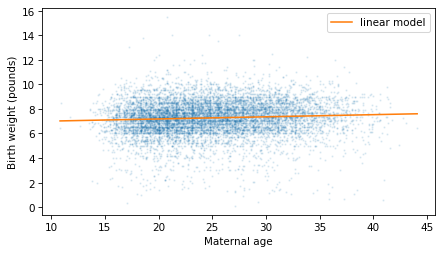

In [35]:
plt.scatter(agepreg, totalwgt, marker=".", alpha=0.1, s=5)
plt.plot(agepreg_range, fit_ys, color="C1", label="linear model")

decorate(xlabel="Maternal age", ylabel="Birth weight (pounds)")

Because the slope of the fitted line is small, we can barely see the difference in the expected birth weight between the youngest and oldest mothers.
The variation in birth weight, at every maternal age, is much larger.

Next we'll use `StatsModels` to confirm that first babies are lighter than others.
To make that work, we'll create a Boolean `Series` that is `True` for first babies and `False` for others, and add it as a new column called `is_first`.

In [36]:
valid["is_first"] = valid["birthord"] == 1

In [37]:
from thinkstats import value_counts

# check the results
value_counts(valid["is_first"])

,count
is_first,
False,4675
True,4363


Here's the formula for a model with birth weight as the response variable and `is_first` as the explanatory variable.
In the Patsy formula language, `C` and the parentheses around the variable name indicate that it is **categorical** -- that is, it represents categories like "first baby" rather than measurements like birth weight.

In [38]:
formula = "totalwgt_lb ~ C(is_first)"

Now we can fit the model and display the results, as usual.

In [39]:
result_first = smf.ols(formula, data=valid).fit()
display_summary(result_first)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.3259,0.021,356.007,0.000,7.286,7.366
C(is_first)[T.True],-0.1248,0.030,-4.212,0.000,-0.183,-0.067


R-squared:,0.00196


In the results, the label `C(is_first)[T.True]` indicates that `is_first` is a categorical variable and the coefficient is associated with the value `True`.
The `T` before `True` stands for "treatment" -- in the language of a controlled experiment, first babies are considered the treatment group and other babies are considered the reference group.
These designations are arbitrary -- we could consider first babies to be the reference group and others to be the treatment group.
But we need to know which is which in order to interpret the results.

The intercept is about 7.3, which means that the average weight of the reference group is 7.3 pounds.
The coefficient of `is_first` is -0.12, which means that the average weight of the treatment group -- first babies -- is 0.12 pounds lighter.
We can check both of these results by computing them directly.

In [40]:
others["totalwgt_lb"].mean()

np.float64(7.325855614973262)

In [41]:
diff_weight = firsts["totalwgt_lb"].mean() - others["totalwgt_lb"].mean()
diff_weight

np.float64(-0.12476118453549034)

In addition to these coefficients, `StatsModels` also computes p-values, confidence intervals, and $R^2$.
The p-value associated with first babies is small, which means that the difference between the groups is statistically significant.
And the $R^2$ value is small, which means that if we're trying to guess the weight of a baby, it doesn't help much to know whether it is a first baby.

Now let's see if it's plausible that the difference in birth weight is due to the difference in maternal age.
On average, mothers of first babies are about 3.6 years younger than other mothers.

In [42]:
diff_age = firsts["agepreg"].mean() - others["agepreg"].mean()
diff_age

np.float64(-3.5864347661500275)

And the slope of birth weight as a function of age is 0.0175 pounds per year.

In [43]:
slope = result_age.params["agepreg"]
slope

np.float64(0.017453851471802638)

If we multiply the slope by the difference in ages, we get the expected difference in birth weight for first babies and others, due to mother's age.

In [44]:
slope * diff_age

np.float64(-0.0625970997216918)

The result is 0.063 pounds, which is about half of the observed difference.
So it seems like the observed difference in birth weight can be partly explained by the difference in mother's age.

Using multiple regression, we can estimate coefficients for maternal age and first babies at the same time.

In [45]:
formula = "totalwgt_lb ~ agepreg + C(is_first)"
result = smf.ols(formula, data=valid).fit()
display_summary(result)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.9142,0.078,89.073,0.000,6.762,7.066
C(is_first)[T.True],-0.0698,0.031,-2.236,0.025,-0.131,-0.009
agepreg,0.0154,0.003,5.499,0.000,0.010,0.021


R-squared:,0.005289


The coefficient of `is_first` is -0.0698, which means that first babies are 0.0698 pounds lighter than others, on average, after accounting for the difference due to maternal age.
That's about half of the difference we get without accounting for maternal age.

And the p-value is 0.025, which is still considered statistically significant, but it is in the borderline range where we can't exclude the possibility that a difference this size could happen by chance.

Because this model takes into account the weight difference due to maternal age, we can say that it **controls for** maternal age.
But it assumes that the relationship between weight and maternal age is linear.
So let's see if that's true.

## Nonlinear Relationships

To check whether the contribution of `agepreg` might be nonlinear, we can add a new column to the dataset, which contains the values of `agepreg` squared.

In [46]:
valid["agepreg2"] = valid["agepreg"] ** 2

Now we can define a model that includes a linear relationship *and* a quadratic relationship.

In [47]:
formula = "totalwgt_lb ~ agepreg + agepreg2"

We can fit the model in the usual way.

In [48]:
result_age2 = smf.ols(formula, data=valid).fit()
display_summary(result_age2)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.5720,0.275,20.226,0.000,5.032,6.112
agepreg,0.1186,0.022,5.485,0.000,0.076,0.161
agepreg2,-0.0019,0.000,-4.714,0.000,-0.003,-0.001


R-squared:,0.00718


The p-value associated with the quadratic term, `agepreg2`, is very small, which suggests that it contributes more information about birth weight than we would expect by chance.
And the $R^2$ value for this model is 0.0072, higher than for the linear model (0.0047).

By estimating coefficients for `agepreg` and `agepreg2`, we are effectively fitting a parabola to the data.
To see that, we can use the `RegressionResults` object to generate predictions for a range of maternal ages.

First we'll create a temporary `DataFrame` that contains columns named `agepreg` and `agepreg2`, based on the range of ages in `agepreg_range`.

In [49]:
df = pd.DataFrame({"agepreg": agepreg_range})
df["agepreg2"] = df["agepreg"] ** 2

Now we can use the `predict` method, passing the `DataFrame` as an argument and getting back a `Series` of predictions.

In [50]:
fit_ys = result_age2.predict(df)

Here's what the fitted parabola looks like, along with a scatter plot of the data.

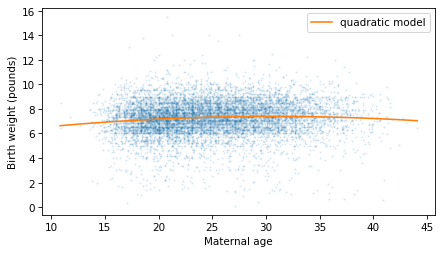

In [51]:
plt.scatter(agepreg, totalwgt, marker=".", alpha=0.1, s=5)
plt.plot(agepreg_range, fit_ys, color="C1", label="quadratic model")

decorate(xlabel="Maternal age", ylabel="Birth weight (pounds)")

The curvature is subtle, but it suggests that birth weights are lower for the youngest and oldest mothers, and higher in the middle.

The quadratic model captures the relationship between these variables better than the linear model, which means it can account more effectively for the difference in birth weight due to maternal age.
So let's see what happens when we add `is_first` to the quadratic model.

In [52]:
formula = "totalwgt_lb ~ agepreg + agepreg2 + C(is_first)"
result = smf.ols(formula, data=valid).fit()
display_summary(result)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.6923,0.286,19.937,0.000,5.133,6.252
C(is_first)[T.True],-0.0504,0.031,-1.602,0.109,-0.112,0.011
agepreg,0.1124,0.022,5.113,0.000,0.069,0.155
agepreg2,-0.0018,0.000,-4.447,0.000,-0.003,-0.001


R-squared:,0.007462


With a more effective control for maternal age, the estimated difference between first babies and others is 0.0504 pounds, smaller than the estimate with just the linear model (0.0698 pounds).
And the p-value associated with `is_first` is 0.109, which mean it is plausible that the remaining difference between these groups is due to chance.

We can conclude that the difference in birth weight is explained -- at least in part and possibly in full -- by the difference in mother's age.

## Logistic Regression

Linear regression is based on a model where the expected value of the response variable is the weighted sum of the explanatory variables and an intercept.
This model is appropriate when the response variable is a continuous quantity like birth weight or penguin mass, but not when the response variable is a discrete quantity like a count or a category.

For these kinds of response variables, we can use **generalized linear models** or GLMs.
For example:

* If the response variable is a count, we can use Poisson regression.

* If it's categorical with only two categories, we can use logistic regression.

* If it's categorical with more than two categories, we can use multinomial logistic regression.

* If it's categorical and the categories can be arranged in order, we can use ordered logistic regression.

We won't cover all of them in this book -- just **logistic regression**, which is the most widely used.
As an example, we'll use the penguin dataset again, and see if we can tell whether a penguin is male or female, based on its weight and other measurements.

`StatsModels` provides a function that does logistic regression -- it's called `logit` because that's the name of a mathematical function that appears in the definition of logistic regression.
Before we can use the `logit` function, we have to transform the response variable so the values are `0` and `1`.

In [53]:
adelie["y"] = (adelie["Sex"] == "MALE").astype(int)

In [54]:
adelie["y"].value_counts()

,count
y,
0,78
1,73


We'll start with a simple model with `y` as the response variable and `mass` as the explanatory variable.
Here's how we make and fit the model -- the argument `disp=False` suppresses messages about the fitting process.

In [55]:
model = smf.logit("y ~ mass", data=adelie)
result = model.fit(disp=False)

And here are the results.

In [56]:
display_summary(result)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-25.9871,4.221,-6.156,0.000,-34.261,-17.713
mass,0.0070,0.001,6.138,0.000,0.005,0.009


Pseudo R-squared:,0.5264


The coefficient of determination, $R^2$, does not apply to logistic regression, but there are several alternatives that are used as "pseudo $R^2$ values."
The pseudo $R^2$ value for this model is about 0.526, which doesn't mean much by itself, but we will use it to compare models.

The coefficient of `mass` is positive, which means that heavier penguins are more likely to be male.
Other than that, the coefficients are not easy to interpret -- we can understand the model better by plotting the predictions.
We'll make a `DataFrame` with a range of values for `mass`, and use `predict` to compute a `Series` of predictions.

In [57]:
mass = adelie["mass"]
mass_range = np.linspace(mass.min(), mass.max())
df = pd.DataFrame({"mass": mass_range})
fit_ys = result.predict(df)

Each predicted value is the probability a penguin is male as a function of its weight.
Here's what the predicted values look like.

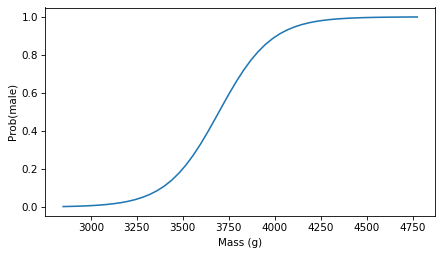

In [58]:
plt.plot(mass_range, fit_ys)

decorate(xlabel="Mass (g)", ylabel="Prob(male)")

The lightest penguins are almost certain to be female, and the heaviest are likely to be male -- in the middle, a penguin weighing 3750 grams is about equally likely to be male or female.

Now let's see what happens if we add the other measurements as explanatory variables.

In [59]:
formula = "y ~ mass + flipper_length + culmen_length + culmen_depth"
model = smf.logit(formula, data=adelie)
result = model.fit(disp=False)
display_summary(result)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-60.6075,13.793,-4.394,0.000,-87.642,-33.573
mass,0.0059,0.001,4.153,0.000,0.003,0.009
flipper_length,-0.0209,0.052,-0.403,0.687,-0.123,0.081
culmen_length,0.6208,0.176,3.536,0.000,0.277,0.965
culmen_depth,1.0111,0.349,2.896,0.004,0.327,1.695


Pseudo R-squared:,0.6622


The pseudo $R^2$ value of this model is 0.662, higher than the previous model (0.526) -- so the additional measurements contain additional information that distinguishes male and female penguins.

The p-values for culmen length and depth are small, which indicates that they contribute more information than we expect by chance.
The p-value for flipper length is large, which suggests that if you know a penguin's weight and bill dimensions, flipper length doesn't contribute additional information.

To understand this model, let's look at some of its predictions.
We'll use the following function, which takes a sequence of masses and a specific value for `culmen_length`.
It sets the other measurements to their mean values, computes predicted probabilities as a function of mass, and plots the results.

In [60]:
def plot_predictions(mass_range, culmen_length, **options):
    """Plot predicted probabilities as a function of mass."""
    df = pd.DataFrame({"mass": mass_range})
    df["flipper_length"] = adelie["flipper_length"].mean()
    df["culmen_length"] = culmen_length
    df["culmen_depth"] = adelie["culmen_depth"].mean()
    fit_ys = result.predict(df)
    plt.plot(mass_range, fit_ys, **options)

Here's what the results look like for three values of `culmen_length`: one standard deviation above average, average, and one standard deviation below average.

In [61]:
culmen_length = adelie["culmen_length"]
m, s = culmen_length.mean(), culmen_length.std()

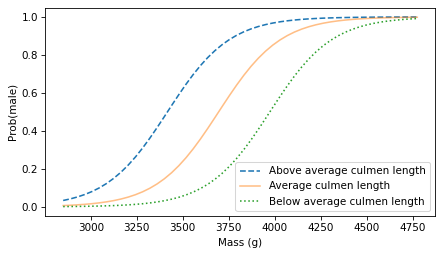

In [62]:
plot_predictions(mass_range, m + s, ls="--", label="Above average culmen length")
plot_predictions(mass_range, m, alpha=0.5, label="Average culmen length")
plot_predictions(mass_range, m - s, ls=":", label="Below average culmen length")

decorate(xlabel="Mass (g)", ylabel="Prob(male)")

As we saw in the simpler model, heavier penguins are more likely to be male.
Also, at any weight, a penguin with a longer bill is more likely to be male.

This model is more useful than it might seem -- in fact, it is similar to models that were used in the original research paper this dataset was collected for.
The primary topic of that research is sexual dimorphism, which is the degree to which male and female bodies differ.
One way to quantify dimorphism is to use measurements to classify males and females.
In a species with higher dimorphism, we expect these classifications to be more accurate.

The original paper is Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

To test this methodology, let's try the same model on a different species.
In addition to the Adélie penguins we've worked with so far, the dataset also contains measurements from 123 Gentoo penguins.
We'll use the following function to select them.

In [63]:
def get_species(penguins, species):
    df = penguins.query(f'Species.str.startswith("{species}")').copy()
    df["y"] = (df["Sex"] == "MALE").astype(int)
    return df

In [64]:
gentoo = get_species(penguins, "Gentoo")
len(gentoo)

123

Here are the results of the logistic regression model.

In [65]:
formula = "y ~ mass + flipper_length + culmen_length + culmen_depth"
model = smf.logit(formula, data=gentoo)
result = model.fit(disp=False)
display_summary(result)

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-173.9123,62.326,-2.790,0.005,-296.069,-51.756
mass,0.0105,0.004,2.948,0.003,0.004,0.017
flipper_length,0.2839,0.183,1.549,0.121,-0.075,0.643
culmen_length,0.2734,0.285,0.958,0.338,-0.286,0.833
culmen_depth,3.0843,1.291,2.389,0.017,0.554,5.614


Pseudo R-squared:,0.848


The pseudo-$R^2$ value is 0.848, higher than what we got with Adélie penguins (0.662).
That means Gentoo penguins can be classified more accurately using physical measurements, compared to Adélie penguins, which suggests that Gentoo penguins are more dimorphic.

## Glossary

-   **regression**: A method for estimating coefficients that fit a model to data.

-   **response variables**: The variables a regression model tries to predict, also known as dependent variables.

-   **explanatory variables**: The variables a model uses to predict the response variables, also known as independent variables.

-   **simple regression**: A regression with one response variable and one explanatory variable.

-   **multiple regression**: A regression with multiple explanatory variables, but only one response variable.

-   **coefficients:** In a regression model, the coefficients are the intercept and the estimated slopes for the explanatory variables.

-   **categorical variable**: A variable that can have one of a discrete set of values, usually not numerical.

-   **control variable**: A variable included in a regression to separate the direct effect of an explanatory variable from an indirect effect.

-   **generalized linear models:** A set of regression models based on different mathematical relationships between the explanatory and response variables.

-   **logistic regression**: A generalized linear model used when the response variable has only two possible values.


## Exercises

### Exercise 11.1

Are baby boys heavier than baby girls? To answer this question, we'll use the NSFG data again.

Fit a linear regression model with `totalwgt_lb` as the response variable and `babysex` as a categorical explanatory variable -- the value of this variable is `1` for boys and `2` for girls.
What is the estimated difference in weight?
Is it statistically significant?
What if you control for the mother's age -- does maternal age account for some or all of the apparent difference?

In [66]:
# Solution goes here

In [67]:
# Solution goes here

In [68]:
# Solution goes here

### Exercise 11.2

The Trivers-Willard hypothesis suggests that for many mammals the sex ratio depends on "maternal condition" -- that is, factors like the mother's age, size, health, and social status.
Some studies have shown this effect among humans, but results are mixed.

See <https://en.wikipedia.org/wiki/Trivers-Willard_hypothesis>.

Let's see if there is a relationship between mother's age and the probability of having a boy.
Fit a logistic regression model with the baby's sex as the response variable and mother's age as an explanatory variable.
Are older mothers more or less likely to have boys?
What if you use a quadratic model of maternal age?

In order to use `babysex` as a response variable in a logistic regression, we'll recode it with the value `1` for boys and `0` for girls.

In [69]:
valid["y"] = (valid["babysex"] == 1).astype(int)

In [70]:
# Solution goes here

In [71]:
# Solution goes here

### Exercise 11.3

For the Adelie penguins, fit a linear regression model that predicts penguin weights as a function of `flipper_length`, `culmen_depth`,  and `Sex` as a categorical variable.
If we control for flipper length and culmen depth, how much heavier are male penguins?
Generate and plot predictions for a range of flipper lengths, for male and female penguins, with `culmen_depth` set to its average value.

In [72]:
# Solution goes here

In [73]:
# Solution goes here

In [74]:
# Solution goes here

### Exercise 11.4

Let's see if Chinstrap penguins are more or less dimorphic than the other penguin species in the dataset, as quantified by the pseudo $R^2$ value of the model.
Use `get_species` to select the Chinstrap penguins, then use logistic regression to fit a logistic regression model with sex as the response variable and all four measurements as explanatory variables.
How does the pseudo $R^2$ value compare to the other models?

In [75]:
chinstrap = get_species(penguins, "Chinstrap")
len(chinstrap)

68

In [76]:
# Solution goes here

In [77]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)